# Model solar panels
This script contains the first model that creates a forecast for the solar panel dataset. Since the client already told us that the moving average was a promising first start, I looked into different models that use a moving average. The ARIMA model is a great (and not too complicated) model that includes a moving average (via: https://cprosenjit.medium.com/10-time-series-forecasting-methods-we-should-know-291037d2e285). This ARIMA model is what I looked into and what I used to forecast the solar data.

In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as smd
from datetime import date

#Load in data
solar_df = pd.read_csv('data/zonnepanelen.csv')
solar_df['timestamp'] = pd.to_datetime(solar_df['timestamp'])
solar_df = solar_df[['timestamp', 'value']]
solar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  3933 non-null   datetime64[ns]
 1   value      3933 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 61.6 KB


## Creating evenly spaced datapoints
With the way OpenRemote handles data, new datapoints aren't coming in consistently. For a model to accurately forecast data, these datapoints need to be spaced out evenly.

In [2]:
indexed = solar_df.set_index('timestamp')
indexed.info()
print(indexed)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3933 entries, 2021-10-18 13:16:55.633000 to 2021-10-28 14:01:25.740000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   3933 non-null   float64
dtypes: float64(1)
memory usage: 61.5 KB
                             value
timestamp                         
2021-10-18 13:16:55.633  -7.552167
2021-10-18 13:45:48.816 -10.644167
2021-10-18 13:45:58.254 -10.644167
2021-10-18 13:50:47.226 -10.644167
2021-10-18 13:50:51.308 -10.644167
...                            ...
2021-10-28 13:59:14.862 -35.362000
2021-10-28 13:59:18.285 -35.362000
2021-10-28 13:59:24.854 -35.362000
2021-10-28 14:01:22.477 -35.362000
2021-10-28 14:01:25.740 -35.362000

[3933 rows x 1 columns]


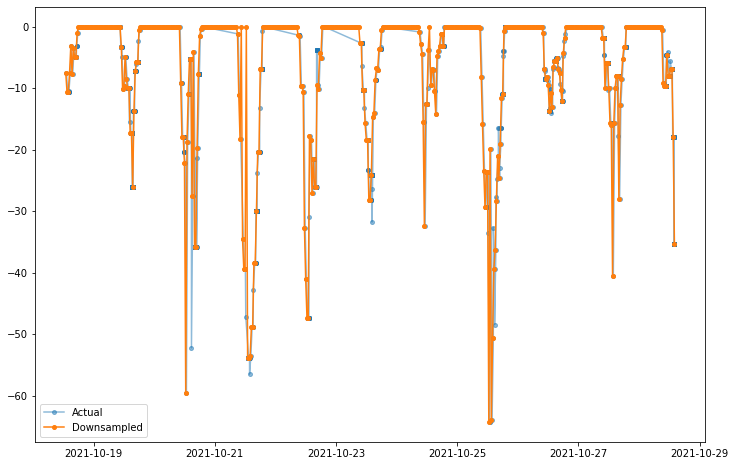

In [10]:
solar_sampled = indexed.resample('30min').agg('first').fillna(0)
plt.figure(figsize=(12,8))
plt.plot(indexed, marker='o', ms=4, alpha=0.5, label='Actual')
plt.plot(solar_sampled, marker='o', ms=4, alpha=1, label='Downsampled')
plt.legend()
plt.show()

In [29]:
print(solar_sampled.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 483 entries, 2021-10-18 13:00:00 to 2021-10-28 14:00:00
Freq: 30T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   483 non-null    float64
dtypes: float64(1)
memory usage: 7.5 KB
None


In [4]:
# Compare the actual value with the RMSE, by looking at what timestamp is closest 
dates = []
test_value = []
for i in solar_sampled.index:
    dates.append(indexed.index[indexed.sort_index().index.get_loc(i, method='nearest')])
    test_value.append(indexed['value'][indexed.sort_index().index.get_loc(i, method='nearest')])
dates = pd.DataFrame(dates)
validation = solar_sampled.copy()
validation['closest_date'] = dates.values
validation['test_value'] = test_value

rmse = np.sqrt(np.mean(validation['value'] - validation['test_value']) **2)
print(rmse)
print(validation)


5.143959165068368
                         value            closest_date  test_value
timestamp                                                         
2021-10-18 13:16:00  -7.552167 2021-10-18 13:16:55.633   -7.552167
2021-10-18 13:17:00   0.000000 2021-10-18 13:16:55.633   -7.552167
2021-10-18 13:18:00   0.000000 2021-10-18 13:16:55.633   -7.552167
2021-10-18 13:19:00   0.000000 2021-10-18 13:16:55.633   -7.552167
2021-10-18 13:20:00   0.000000 2021-10-18 13:16:55.633   -7.552167
...                        ...                     ...         ...
2021-10-28 13:57:00   0.000000 2021-10-28 13:56:24.899  -35.362000
2021-10-28 13:58:00 -35.362000 2021-10-28 13:58:18.361  -35.362000
2021-10-28 13:59:00 -35.362000 2021-10-28 13:59:01.488  -35.362000
2021-10-28 14:00:00   0.000000 2021-10-28 13:59:24.854  -35.362000
2021-10-28 14:01:00 -35.362000 2021-10-28 14:01:22.477  -35.362000

[14446 rows x 3 columns]


By downsampling the data and taking the mean of each hour, I evenly space out the datapoints so it's possible to use a model on them. The charts above show the downsampled (clean) data and its comparison to the original data.

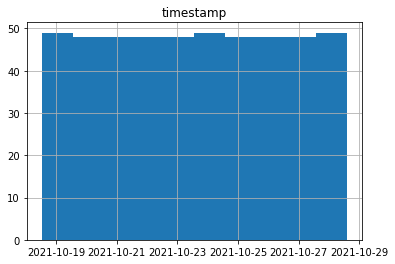

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 483 entries, 2021-10-18 13:00:00 to 2021-10-28 14:00:00
Freq: 30T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   483 non-null    float64
dtypes: float64(1)
memory usage: 7.5 KB
None


In [5]:
pd.DataFrame(solar_sampled.index).hist()
plt.show()
print(solar_sampled.info())

The above histogram shows that the datapoints are now spaced out evenly.

## Box Jenkins method
To learn how to implement the ARIMA model, I first followed a Datacamp course(ARIMA models in Python). Through this method I learned the Box Jenkins method, which divides modelling into three important steps:
1. Identification
2. Estimation
3. Model diagnostics

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
training_df = solar_sampled.iloc[:int(round(solar_sampled.count()*0.65))]
test_df = solar_sampled.iloc[1 + int(round(solar_sampled.count()*0.65)):]

# Identification
print(adfuller(solar_sampled)[0:2])

(-6.724936580821115, 3.4084993022167197e-09)


### Identification
To correctly predict time-series data, it is important the data is stationary. This means that the data is evenly distributed, has low variance and there's no trend. After downsampling the data so that the time between datapoints is the same, the data matches all of these criteria. To test the stationarity of the data, the Dicky-Fuller test can be used. The first two numbers in this test are important for our dataset. The first value is the test statistic. The more negative this is, the higher the probability that the data is stationary. -6.87 is an acceptable value. 
The second value is the p-value, which is more important. The closer this value is to zero, the higher the certainty of the data's stationarity. If this value is below 0.05, you can say for certain that the data is stationary. In this case, the p-value is definitely close to zero.
This is good news, since the data doesn't need to be formatted to be more stationary.

Now that it's clear the data is stationary, it is time to estimate what the best order for the ARIMA model is.

### Estimation

/Users/markvrijhof/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


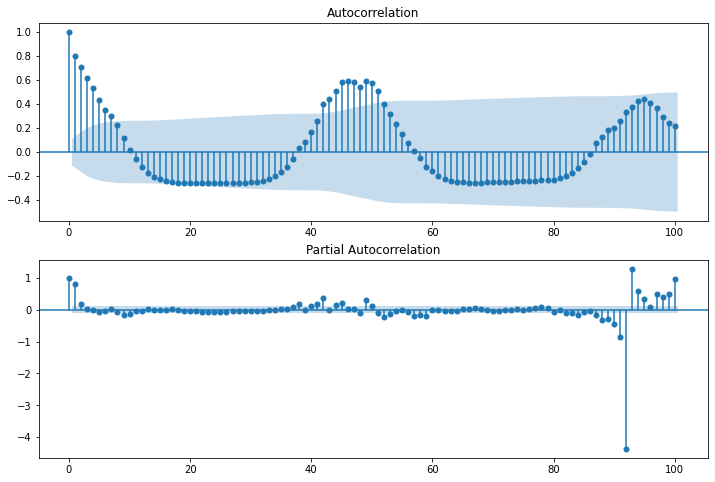

In [7]:
# Estimation
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(training_df, lags=100, ax=ax1)
plot_pacf(training_df, lags=100, ax=ax2)
plt.show()

Plotting the autocorrelation shows a clear pattern (seasonality). Each 24 hours this pattern repeats. However, since the the autocorrelation slowly decreases it is helpful to difference the data and see what that results in. During the identification step I concluded that the data is stationary, but it looks like differencing it once is a good thing to do.

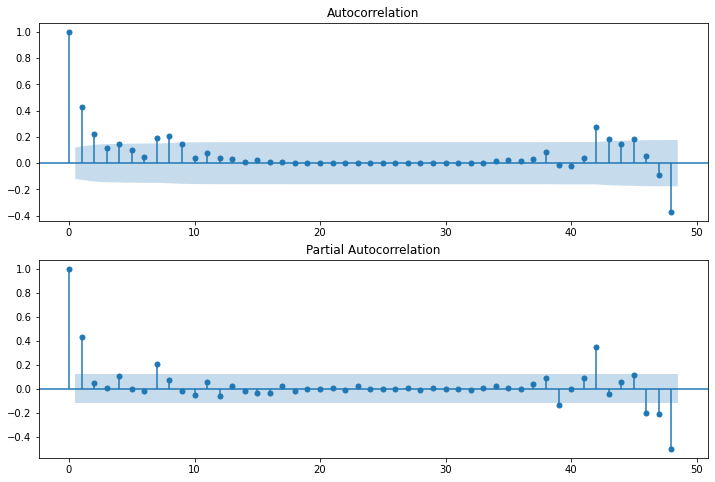

In [8]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
input = training_df.diff(48).dropna()
plot_acf(input, lags=48, ax=ax1)
plot_pacf(input, lags=48, ax=ax2)
plt.show()

After differencing the data, the autocorrelation quickly cuts off, which is what we want.

Instead of using a trial and error method myself, I can use a function called 'auto_arima' to do the guessing work for me. This function loops through different orders to check which one is best suited for our data. The lower the AIC score (which is a sort of test), the better the model is suited.

In [24]:
# Pick an appropriate model
test_model = pm.auto_arima(training_df, seasonal=True, m=48, error_action='ignore', trace=True, D=1)
print(test_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[48]             : AIC=inf, Time=31.25 sec
 ARIMA(0,1,0)(0,1,0)[48]             : AIC=2080.763, Time=0.21 sec
 ARIMA(1,1,0)(1,1,0)[48]             : AIC=1929.589, Time=2.62 sec
 ARIMA(0,1,1)(0,1,1)[48]             : AIC=inf, Time=11.74 sec
 ARIMA(1,1,0)(0,1,0)[48]             : AIC=2054.037, Time=0.41 sec
 ARIMA(1,1,0)(2,1,0)[48]             : AIC=inf, Time=10.16 sec
 ARIMA(1,1,0)(1,1,1)[48]             : AIC=inf, Time=14.76 sec
 ARIMA(1,1,0)(0,1,1)[48]             : AIC=inf, Time=16.44 sec
 ARIMA(1,1,0)(2,1,1)[48]             : AIC=inf, Time=60.53 sec
 ARIMA(0,1,0)(1,1,0)[48]             : AIC=1970.293, Time=1.73 sec
 ARIMA(2,1,0)(1,1,0)[48]             : AIC=1919.421, Time=3.41 sec
 ARIMA(2,1,0)(0,1,0)[48]             : AIC=2044.276, Time=0.58 sec
 ARIMA(2,1,0)(2,1,0)[48]             : AIC=inf, Time=12.66 sec
 ARIMA(2,1,0)(1,1,1)[48]             : AIC=inf, Time=113.15 sec
 ARIMA(2,1,0)(0,1,1)[48]             : AIC=inf, Ti

In [25]:
# The orders below are what change the way the model forecasts and how accurate these are.
results = SARIMAX(training_df, order=(3,1,1), seasonal_order=(2,1,0,48)).fit(disp=0)
forecast = pd.DataFrame(results.get_forecast(steps=168).predicted_mean)
forecast.index.name = 'timestamp'

<Figure size 432x288 with 0 Axes>

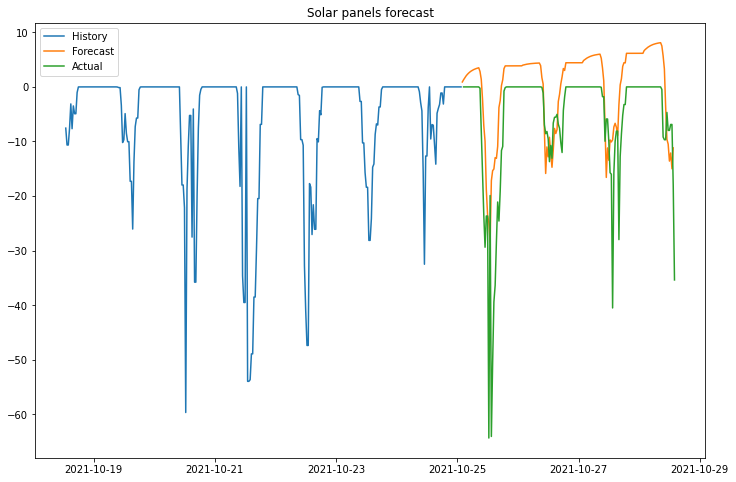

                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  314
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 48)   Log Likelihood                -931.427
Date:                             Thu, 09 Jun 2022   AIC                           1876.855
Time:                                     23:19:24   BIC                           1901.913
Sample:                                 10-18-2021   HQIC                          1886.923
                                      - 10-25-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4556      0.045     10.170      0.000       0.368       0.543
ar.L2          0.1857      

/Users/markvrijhof/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


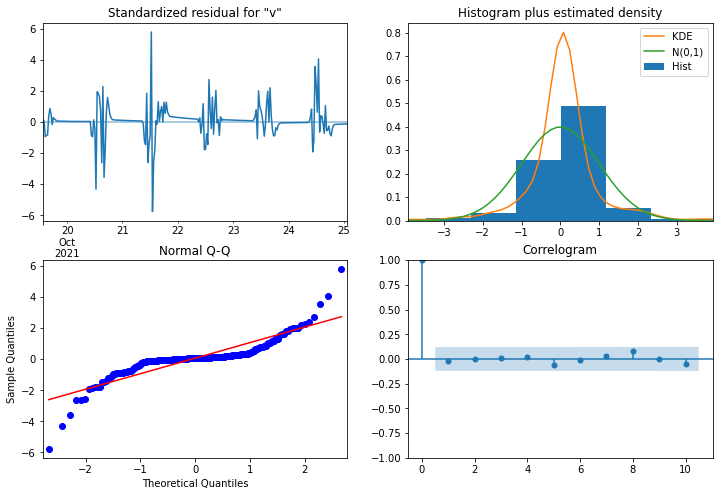

In [26]:
plt.clf()
plt.figure(figsize=(12,8))
plt.plot(training_df, label='History')
plt.plot(forecast, label='Forecast')
plt.plot(test_df, label='Actual')
plt.legend()
plt.title('Solar panels forecast')
plt.show()
print(results.summary())
results.plot_diagnostics(figsize=(12,8))
plt.show()

The forecast looks similar to the training data, but when comparing it to the test data, it doesn't always accurately predict how high spikes are. Trying different orders changes the prediction, but the one above is the best prediction I've gotten. When looking at the 4 diagnostics, they show that the model can still be improved, but I haven't gotten this to work. The standardized residual chart shows the difference between the actual value and the forecasted value and should therefore be similar to white noise, without any pattern. This means that the errors are without a pattern and can't really be forecasted. In the chart above, there is actually a clear pattern in the residuals which shows that there might be a pattern the model is not picking up.
Besides that, in the second chart, the KDE and N should line up more, but they deviate a lot. This means the data isn't normally distributed.
In the Normal QQ chart, the dots should line up with the red line. In this case, they fluctuate a lot, which isn't what we want to see. 
Overall, when looking at the diagnostics, the model can definitely be improved, but trying different orders doesn't change this. 

In [27]:
# Root Mean Squared Error
import math
MSE = np.square(np.subtract(test_df,forecast)).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

9.209530573879643


/var/folders/np/9vd9gx5163l0kjxgkkx1scpm0000gn/T/ipykernel_73457/1076375909.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  MSE = np.square(np.subtract(test_df,forecast)).mean()


In [28]:
# Calculate RMSE percentage
min = solar_sampled['value'].min()
max = solar_sampled['value'].max()
print(RMSE / (max-min) * 100)

14.31911638040627


In [18]:
print(len(training_df), len(forecast))

314 168


                     lower value  upper value
timestamp                                    
2021-10-23 00:00:00   -13.540467    13.538925
2021-10-23 00:30:00   -13.540052    13.539340
2021-10-23 01:00:00   -13.539861    13.539532
2021-10-23 01:30:00   -13.539772    13.539620
2021-10-23 02:00:00   -13.539731    13.539661
...                          ...          ...
2021-10-24 23:30:00   -13.536069    13.543323
2021-10-25 00:00:00   -13.538021    13.541372
2021-10-25 00:30:00   -13.538922    13.540470
2021-10-25 01:00:00   -13.539339    13.540054
2021-10-25 01:30:00   -13.539531    13.539861

[100 rows x 2 columns]


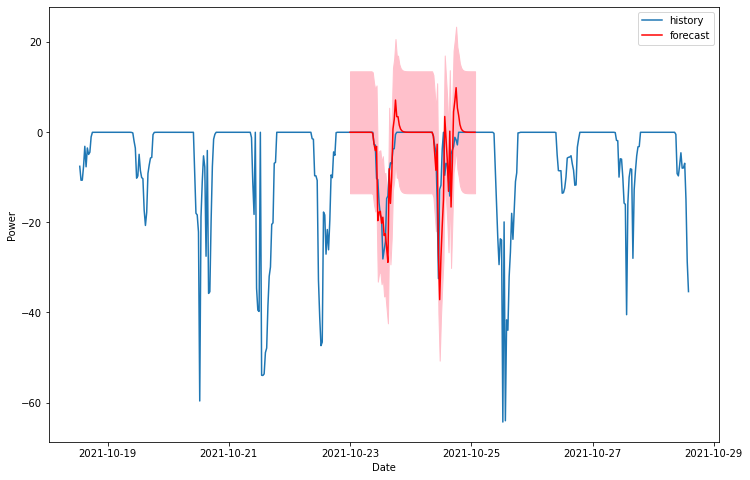

In [16]:
# This is just some test code that doesn't really do a forecast so can be discarded. I have decided to leave it in anyways since it is still something I have made.
one_step_forecast = results.get_prediction(start=-100)
mean_forecast = one_step_forecast.predicted_mean
print(one_step_forecast.conf_int())
lower_limit = one_step_forecast.conf_int().loc[:,'lower value']
upper_limit = one_step_forecast.conf_int().loc[:,'upper value']
plt.figure(figsize=(12,8))
plt.plot(solar_sampled, label='history')
plt.plot(mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limit.index, lower_limit, upper_limit, color='pink')
plt.xlabel('Date')
plt.ylabel('Power')
plt.legend()
plt.show()

In [68]:
# Format the forecasted data into OR format
training_export = training_df.reset_index()
forecast_export = forecast.copy()
forecast_export.reset_index(inplace=True)
forecast_export.rename(columns={'predicted_mean':'value'}, inplace=True)
forecast_export

,timestamp,value
0,2021-10-25 02:00:00,0.000076
1,2021-10-25 02:30:00,0.000076
2,2021-10-25 03:00:00,0.000076
3,2021-10-25 03:30:00,0.000076
4,2021-10-25 04:00:00,0.000076
...,...,...
139,2021-10-27 23:30:00,0.000092
140,2021-10-28 00:00:00,0.000092
141,2021-10-28 00:30:00,0.000092
142,2021-10-28 01:00:00,0.000092


In [69]:
# Exporting the data into csv, so it can be used for the OR integration
training_export.to_json('training_data.json', orient='records')
forecast_export.to_json('forecast_data.json', orient='records')